### Let's import some libraries

In [5]:
import numpy as np
import pyart
from pyscancf import pyscancf as pcf
import matplotlib.pyplot as plt
import xarray as xr
import glob

### Specify the input data directory and where do you want to save out data 

In [2]:
indir = 'B16'
outdir = 'B16/output/'

### if you want only polar data you have to put gridder option False, otherwise True,
Here, I will put it fasle and create only polar data, later I will call get_grid function and convert it to grid separately.

In [3]:
pcf.cfrad(input_dir=indir, output_dir=outdir, gridder=False)

Number of files:  20
Total number of files will be created:  2
Merging all scans in one file
Data merging done 
Total Time Elapsed:  0:04:24.856410


### Now the polar data is generated, let's read polar data through pyart

In [6]:
polar_files = sorted(glob.glob('B16/output/polar*nc'))
print(len(polar_files))

2


In [7]:
print(polar_files)

['B16/output/polar_GOA210516141806.nc', 'B16/output/polar_GOA210516142916.nc']


Let's save our data in radars list

In [9]:
radars = []
for file in polar_files:
    radar = pyart.io.read_cfradial(file)
    radars.append(radar)

In [14]:
radars[0].info()

altitude:
	data: <ndarray of type: float32 and shape: (1,)>
	long_name: Altitude
	units: meters
	standard_name: Altitude
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (3600,)>
	long_name: azimuth_angle_from_true_north
	units: degrees
	standard_name: beam_azimuth_angle
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (3600,)>
	long_name: elevation_angle_from_horizontal_plane
	units: degrees
	standard_name: beam_elevation_angle
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	REF:
		data: <ndarray of type: float32 and shape: (3600, 996)>
		long_name: Reflectivity
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		coordinates: elevation azimuth range
	VELH:
		data: <ndarray of type: float32 and shape: (3600, 996)>
		units: m/s
		standard_name: Radial Velocity
	WIDTH

In [16]:
### Lets create a display,  suppose we will want to see what is in these two file;

In [21]:
for radar in radars:
    print(radar.fields.keys())

dict_keys(['REF', 'VELH', 'WIDTHH', 'TP'])
dict_keys(['REF', 'VELH', 'WIDTHH', 'TP'])


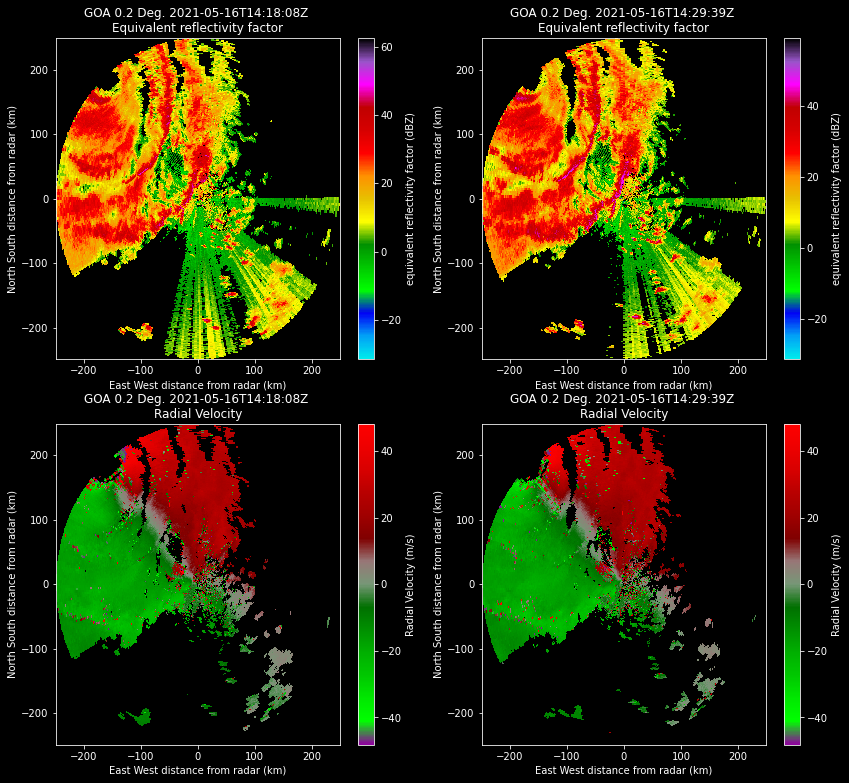

In [55]:
fig = plt.figure(figsize=[14,13])
for i in range(len(radars)):
    display = pyart.graph.RadarDisplay(radars[i])    
    display.plot('REF',sweep=0,cmap='pyart_NWSRef',ax = plt.subplot(2,2,i+1))
    display.plot('VELH',sweep=0,cmap='pyart_NWSVel',ax=plt.subplot(2,2,i+3))
plt.show()

In [101]:
import wradlib as wrl

In [109]:
first_sweep = radar.fields['REF']['data'][radar.get_slice(0)] ## take only rain of first sweep
first_sweep.shape

(360, 996)

In [110]:
p_rain = []
for radar in radars:
    polar_rain = wrl.zr.z_to_r(wrl.trafo.idecibel(first_sweep))
    p_rain.extend(polar_rain)

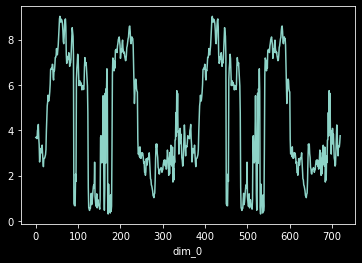

In [123]:
xr.DataArray(p_rain).mean(axis=1).plot()

In [111]:
len(p_rain)

720

### Now let's create this polar data to grid

In [61]:
from netCDF4 import num2date

In [86]:
for radar in radars:
    grid = pcf.get_grid(radar)
    pyart.io.write_grid(outdir+'grid_'+num2date(
        radar.time['data'],radar.time['units'])[0].strftime('%Y%m%d%H%M%S')+'.nc',grid)

### Now we have created grid files, lets read them, with pyart

In [146]:
grid_files = sorted(glob.glob('B16/output/grid*nc'))
print(len(grid_files))                              

2


Generating Figures of Max-CAPPI, please be patient!
Figures saved
Generating Figures of Max-CAPPI, please be patient!
Figures saved


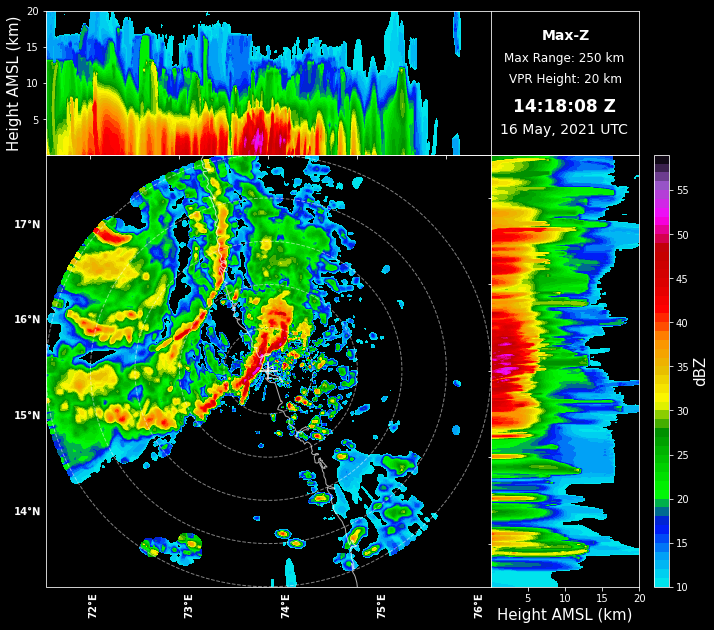

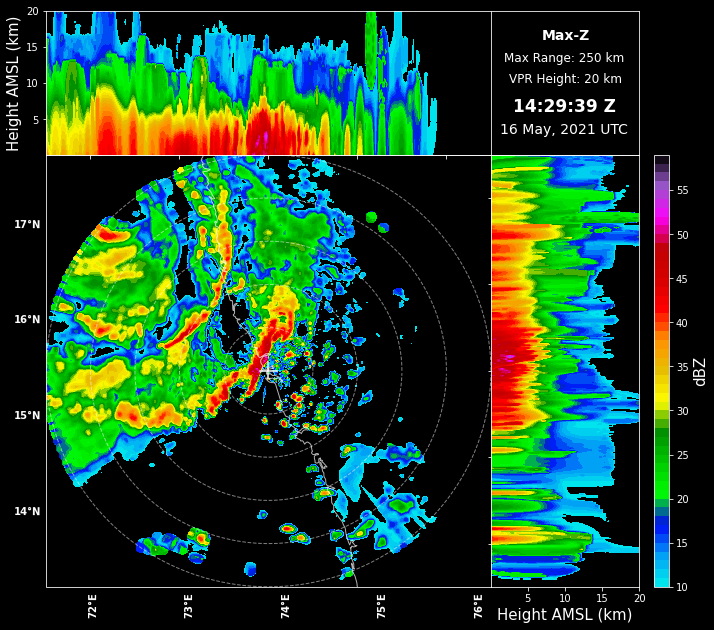

In [158]:
grids = []
for gfile in grid_files:
    grid = pyart.io.read_grid(gfile)
    pcf.plot_cappi(grid,'REF')
    grids.append(grid)   